# Code Functionality

This code takes nodes as input , connects the consecutive nodes to form elements. Then assembles the global stiffness matrix . This code is considers 3 DOF at each node but can be extended to 6 DOF considering rotations. The user can input forces at node and define the BC. The code then solves and outputs the displacements and reaction forces

In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:

#------------------------CLASS NODE-----------------------------------
class Node:

  def __init__(self,x,y): ##inputs 2 coordinates
    self.coord=np.array([x,y])



#------------------------CLASS ELEMENT-----------------------------------
## creates one-D element from the coordinates and plots
class element:
  def __init__(self,nodes,stiffness,area):
    self.nodes=nodes ##node is a list
    self.nnodes=len(nodes) ## number of nodes based on the input
    self.space_dimensions=len(self.nodes[0].coord) #number of inputes, (x,y) or (x,y,z)
    self.dof=self.space_dimensions*1 ##calculates number of dof 1, if only translation , 2 if both translation and rotation
    self.k_dimension=self.nnodes*self.dof ##dimension of the stiffness matrix
    self.ele_length,self.ele_norm=self.cal_length()
    self.E=stiffness
    self.A=area
    self.k_global=self.global_stiffness()
  #--------------for plotting and printing---------------------
    print(f"-------Checking the Input----------:\n")
    # print(f"-------Geometry Properties----------:\n")
    # print(f"Number of nodes: {self.nnodes}")
    # print(f"Number of coordinates: {self.space_dimensions}\n")
    # print(f"Number of DOF: {self.dof}\n")
    print(f"Dimension of the stiffness (global K) matrix: {self.k_dimension}\n")


  #   print(f"-------Material Properties----------:\n")
  #   print(f"Youngs Modulus [Pa]: {self.E}")
  #   print(f"Element CSA [m^2]: {self.A}")
  #  # print(f"------------------------------:\n")

    print(f"-------element Properties----------:\n")
    for i in range(self.nnodes-1):
     # print(f"Node {i+1} coordinate: {self.nodes[i].coord}")
      print(f"Element {i+1} Length [m]: {self.ele_length[i]}")
      print(f"Element {i+1} Direction Cosine: {self.ele_norm[i]}")
    print(f"------------------------------:\n")

    print(f"-------Stiffness Matrix----------:\n")
    print(f"Global K dimension :\n {self.k_dimension}")

    #print(f"k_local :\n {self.k_local}")
    print(f" Global Stiffness: \n {self.k_global}")
    print(f"------------------------------:\n")


    self.plot_ele()
#-----------------function to calculate the dimensions--------------
  def cal_length(self):
      L_vec_list = []
      length_list = []
      norm_list = []
      for n in range((self.nnodes)-1):
        L_vec=self.nodes[n+1].coord-self.nodes[n].coord #difference between coordinate
        length=np.linalg.norm(L_vec) ##length magnitude
        norm_L=L_vec/length ##direction cosine
        length_list.append(length)
        L_vec_list.append(L_vec)
        norm_list.append(norm_L)
      return np.array(length_list), np.array(norm_list)

   ##--------assembling global stiffness matrix--------
  def global_stiffness(self):
    n_elem = len(self.ele_length)
    total_dof = self.dof * (n_elem + 1)
    K_global = np.zeros((total_dof, total_dof))
    for i in range(n_elem):
        L = self.ele_length[i]
        n = self.ele_norm[i]
        k_local = self.E * self.A / L * np.outer(n, n)
        # 2-node local matrix because considers only one element
        k = np.zeros((2*self.dof, 2*self.dof))
        k[:self.dof, :self.dof] = k_local
        k[:self.dof, self.dof:] = -k_local
        k[self.dof:, :self.dof] = -k_local
        k[self.dof:, self.dof:] = k_local
        # Assemble into the full multi-node stiffness
        start = i * self.dof
        end = (i + 2) * self.dof
        K_global[start:end, start:end] += k
    return K_global
  #-----------------------function to plot------------------------------------
  def plot_ele(self,show=True):
    for n in range((self.nnodes)-1):
      x_values=[self.nodes[n].coord[0], self.nodes[n+1].coord[0]]
      y_values=[self.nodes[n].coord[1], self.nodes[n+1].coord[1]]
      plt.scatter(x_values,y_values,color='blue')
      plt.plot(x_values,y_values,'--',color='black')
    if show:
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.title('Structure')
            plt.grid(True)
            plt.axis('equal')
            plt.show()


##  input values

-------Checking the Input----------:

Dimension of the stiffness (global K) matrix: 4

-------element Properties----------:

Element 1 Length [m]: 3.0
Element 1 Direction Cosine: [1. 0.]
------------------------------:

-------Stiffness Matrix----------:

Global K dimension :
 4
 Global Stiffness: 
 [[ 7.e+08  0.e+00 -7.e+08  0.e+00]
 [ 0.e+00  0.e+00  0.e+00  0.e+00]
 [-7.e+08  0.e+00  7.e+08  0.e+00]
 [ 0.e+00  0.e+00  0.e+00  0.e+00]]
------------------------------:



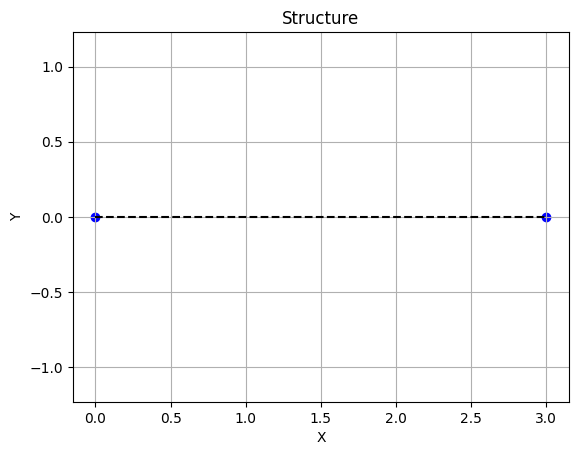

In [3]:
n1 =Node(0,0)
n2 =Node(3,0)
n3=Node(9,0)


nodes = [n1,n2]
e1 = element(nodes, 210e9, 0.01)



In [4]:
class force:
  def __init__(self,nodes,value):
    self.nodes=nodes
    self.value=value

In [5]:
K = e1.global_stiffness()

num_nodes=e1.nnodes
num_dof=e1.dof
nn=e1.nodes



## apply force

In [6]:
if K.shape[0]==K.shape[1]:
   F=np.zeros(K.shape[0])
F[2]=1000
print(F)
fixed_dof = [0, 1,3,4,5] # Node 1 fixed in x and y, Node 3 fixed in y

[   0.    0. 1000.    0.]


## Apply BC

In [7]:
def apply_boundary_conditions(K, F, fixed_dof):
    all_dof = np.arange(K.shape[0])               # all indices
    free_dof = np.setdiff1d(all_dof, fixed_dof)   # removes constrained ones
    K_ff = K[np.ix_(free_dof, free_dof)]          # reduced stiffness matrix
    F_f = F[free_dof]                             # reduced force vector
    return K_ff, F_f, free_dof



In [ ]:
#apply_boundary_conditions(K, F, fixed_dof)

## Solving

In [8]:
K_ff, F_f, free_dof = apply_boundary_conditions(K, F, fixed_dof)
u_f = np.linalg.solve(K_ff, F_f)
u = np.zeros(K.shape[0])
u[free_dof] = u_f
R = K.dot(u) - F

print("Displacements:\n", u)
print("Reactions:\n", R)

Displacements:
 [0.00000000e+00 0.00000000e+00 1.42857143e-06 0.00000000e+00]
Reactions:
 [-1000.     0.     0.     0.]


## Plotting deformed and undeformed

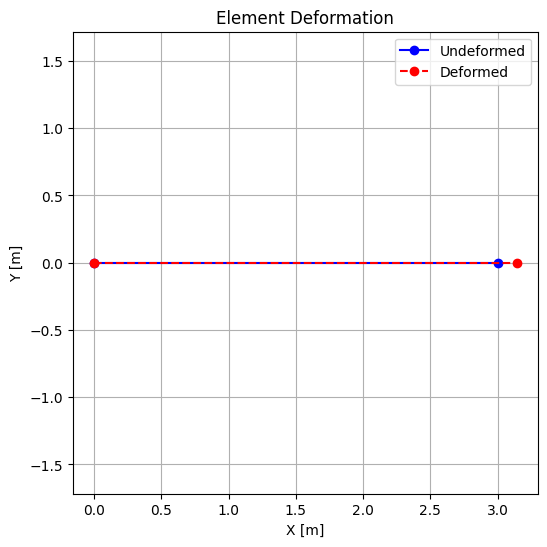

In [ ]:

# Scale factor to visualize tiny displacements
scale = 1e5

# Collect undeformed coordinates
x_undeformed = [node.coord[0] for node in nn]
y_undeformed = [node.coord[1] for node in nn]


x_deformed = []
y_deformed = []

for i, node in enumerate(nn):
    # u has 2 DOFs per node (X,Y)
    ux = u[i*2]
    uy = u[i*2 + 1]
    x_deformed.append(node.coord[0] + scale*ux)
    y_deformed.append(node.coord[1] + scale*uy)

plt.figure(figsize=(6,6))

# Undeformed
plt.plot(x_undeformed, y_undeformed, 'bo-', label='Undeformed')

# Deformed
plt.plot(x_deformed, y_deformed, 'ro--', label='Deformed')

plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('Element Deformation')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()
